# Model Inputs

### Packages

In [1]:
# General
import pandas as pd
import numpy as np
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

# Pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.decomposition import PCA 
import umap
import hdbscan

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Visualization
import plotly.express as px
import plotly.graph_objects as go

### Dataset

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, "model", "ml_input.csv"), low_memory=False)

filter = df["ec"].str.contains("-") # filter non-specific ec numbers, e.g., 1.1.1.-
df = df[~filter]

df = df[["taxon_id", "media_id", "ec"]].value_counts().reset_index()
df = df.pivot(index=["taxon_id", "media_id"], columns="ec", values="count")
df = df.fillna(0.0).reset_index()

# Filtering into training and test sets (database set vs. MAGs)
bins = df["media_id"].str.contains("unknown")
df_train = df[~bins]

df_train

ec,taxon_id,media_id,1.1.1.1,1.1.1.100,1.1.1.102,1.1.1.103,1.1.1.107,1.1.1.108,1.1.1.11,1.1.1.110,...,7.6.2.12,7.6.2.13,7.6.2.14,7.6.2.15,7.6.2.16,7.6.2.2,7.6.2.5,7.6.2.7,7.6.2.8,7.6.2.9
0,100.0,J346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,J386,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100225.0,J233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002526.0,J22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004166.0,1a,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,99655.0,J386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8460,99675.0,J14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8461,99675.0,J84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8462,99807.0,J26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model

### Training and test sets

In [4]:
# Split the datasets into training and test sets
TARGET = "taxon_id" # target label
RANDOM_SEED = 47 # seed for random_state

# Model validation with only labeled samples from data.ipynb
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["taxon_id", "media_id"], axis=1),
    df_train[TARGET],
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, silhouette_score
import umap
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: scale data
    ('pca', PCA(n_components=120)),  # Reduce dimensionality with PCA
    ('umap', umap.UMAP(  # UMAP step
        metric="euclidean",
        n_epochs=200,
        random_state=RANDOM_SEED,
        n_jobs=1
    ))
])

# Define parameter grid with correct step names
param_distributions = {
    'umap__n_components': [10, 20, 30, 50],
    'umap__n_neighbors': [40, 50, 60, 70], 
    'umap__min_dist': [0, 0.2, 0.4, 0.6]
}

# Custom scorer function
def umap_silhouette(X, y):
    embedding = X  # X here is already the transformed data by UMAP
    return silhouette_score(embedding, y)

# Wrap the custom scorer
scorer = make_scorer(umap_silhouette, greater_is_better=True)

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    scoring=scorer
)

# Fit the search to your data
search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = search.best_params_
best_model = search.best_estimator_

print("Best Parameters:", best_params)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'umap__n_neighbors': 40, 'umap__n_components': 30, 'umap__min_dist': 0.4}


### Pipeline

In [6]:
# Split the datasets into training and test sets
TARGET = "media_id" # target label
RANDOM_SEED = 47 # seed for random_state

# Model validation with only labeled samples from data.ipynb
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["taxon_id", "media_id"], axis=1),
    df_train[TARGET],
    test_size=0.2,
    random_state=RANDOM_SEED
)

In [7]:
# sklearn pipeline helps prevent data leakage; incorporate individual steps here
pipeline = Pipeline([
    ('scaler', StandardScaler()),    # Scale data (optional)
    ('pca', PCA(n_components=120)),   # Reduce dimensionality with PCA
    ('umap', umap.UMAP(              # Further reduce with UMAP
        metric="euclidean",
        n_epochs=200, #200 recommended for large datasets, higher => stricter clustering
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_components=30, #20 for clustering, 2 for visualization
        n_neighbors=40,
        min_dist=0.4
        )) 
])

### Fit and transform

In [8]:
# Fit and transform the pipeline on the training and test data
X_train_transformed = pipeline.fit_transform(X_train) # fit pipeline and transform training data
X_test_transformed = pipeline.transform(X_test) # transform test data

### Optimizing n_clusters

In [9]:
# Silhouette coefficient method
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Test a range of clusters for their silhouette coefficients
clusters = []
for n_cluster in range(10, 200):
    kmeans = KMeans(n_clusters=n_cluster).fit(X_train_transformed)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_train_transformed, label, metric='euclidean')
    clusters.append({'n_clusters': n_cluster, 'coefficient': sil_coeff})

# Select the maximum coefficient
clusters = pd.DataFrame(clusters)
c = clusters.iloc[clusters["coefficient"].argmax()]["n_clusters"]
s = clusters["coefficient"].max()
n = int(c)

print("{} clusters returns a maximum Silhouette Coefficient of {}".format(n, s))

181 clusters returns a maximum Silhouette Coefficient of 0.6900811195373535


In [10]:
# Cluster using maximum coefficient's n_clusters
clusterer = KMeans(n_clusters=n, random_state=RANDOM_SEED)
cluster_labels = clusterer.fit_predict(X_train_transformed)
test_clusters = clusterer.predict(X_test_transformed)

### Metrics

In [11]:
# Initial dimensionality reduction performance (PCA)
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
print(f"Total PCA explained variance: {explained_variance.sum()}")

# Further dimensionality reduction and clustering performance
silhouette_avg = silhouette_score(X_train_transformed, cluster_labels)
print(clusterer.labels_.max()+1, "KMeans training clusters")
print(f"Average Silhouette Score on KMeans clusters: {silhouette_avg}")
    # Silhouette score <=0.25 implies poor clustering, 0.25<x<=0.50 is fair, <50 is good

Total PCA explained variance: 0.853626175850595
181 KMeans training clusters
Average Silhouette Score on KMeans clusters: 0.6531764268875122


In [12]:
# Compare to hdbscan clustering 

# Apply HDBSCAN clustering on the transformed training data
hclusterer = hdbscan.HDBSCAN(
    min_samples=5, 
    min_cluster_size=15, 
    #gen_min_span_tree=True, 
    prediction_data=True # cluster_selection_method="leaf", for more fine-grained clustering
)
hcluster_labels = hclusterer.fit_predict(X_train_transformed)

# Clustering performance (UMAP and hdbscan)
hsilhouette_avg = silhouette_score(X_train_transformed, hcluster_labels)
print(hclusterer.labels_.max(), "hdbscan training clusters")
print(f"Silhouette Score on hdbscan clusters: {hsilhouette_avg}")

# Convert to numpy array for hdbscan and predict clustering
#test_points = test_df[["Component 1", "Component 2"]].to_numpy()
#test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)

# Optional constraints
#filtered = train_df[train_df['Cluster'] >= 0]
#test_labels = clusterer.fit_predict(X_test_transformed)

128 hdbscan training clusters
Silhouette Score on hdbscan clusters: 0.5032156109809875


# Classifier

### Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_transformed, cluster_labels)

print(neigh.predict(X_test_transformed))
distances, indices = neigh.kneighbors(X_test_transformed)

[ 31  94  73 ...  37 143  89]


In [14]:
len(neigh.predict(X_test_transformed))

1693

### Random Forest

In [15]:
y_train = cluster_labels
y_test = test_clusters

In [16]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

model.fit(X_train_transformed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=47)

In [17]:
report = classification_report(
    y_true=y_test,
    y_pred=model.predict(X_test_transformed),
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00        38
           3       0.89      1.00      0.94         8
           4       1.00      0.62      0.77        16
           5       1.00      1.00      1.00        45
           6       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        27
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        12
          12       0.87      0.93      0.90        14
          13       1.00      1.00      1.00         8
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00         6
          17       1.00      1.00      1.00        22
          18       1.00    

In [18]:
from sklearn import metrics

roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test_transformed),
    labels=np.unique(y_train),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9999627561654263


# Feature Importance

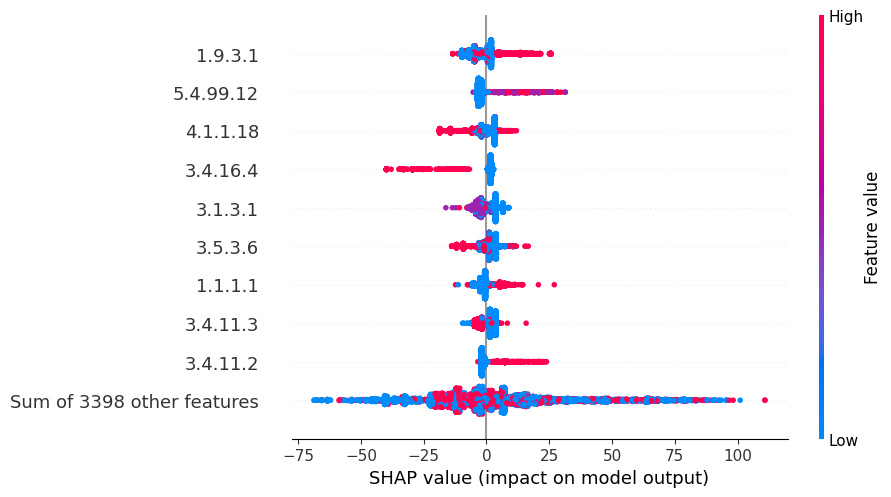

In [19]:
import xgboost
import shap

# train an XGBoost model
model2 = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model2)
shap_values = explainer(X_train)

shap.plots.initjs()
shap.plots.beeswarm(shap_values)